In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
import multiprocessing
import folium
import textwrap

#Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, PolynomialFeatures, OneHotEncoder as ohc
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer,make_column_selector,make_column_transformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration
from sklearn import random_projection
from imblearn.over_sampling import SMOTE

#Analysis
from pandas.plotting import scatter_matrix
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, Animation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter
from IPython.display import display

#Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVR, LinearSVR, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, ExtraTreesRegressor, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression


#Testing & Model Selection
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, mean_squared_error as mse, r2_score, ConfusionMatrixDisplay,accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score, classification_report
from sklearn.feature_selection import VarianceThreshold


In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Directories
training_dir = '/content/drive/My Drive/Colab Notebooks/DSP577/Student_Info_v2.csv'
Table = pd.read_csv(training_dir, encoding='latin1')

# Identifies target feature
target = 'Decision'

Table.head(3)

Student_Type  Age Hispanic Sex  Gender                       Race  \
0     Transfer   19        N   M    Male                      White   
1     Transfer   21        N   F  Female  Black or African American   
2     Transfer   20        N   M    Male                      Asian   

  Entry_Term Decision     Citizenship                  Major  ...   ZIP  \
0       Fall    Other     Born in USA  Computer Science (BS)  ...  2864   
1       Fall    Other  Non-US Citizen       Nursing (B.S.N.)  ...  2301   
2       Fall    Other     Born in USA                Finance  ...  2864   

     Lat   Long  Country  First_Generation  City_Population  \
0  41.94 -71.41      USA                 N            33700   
1  42.08 -71.02      USA                 N            93990   
2  41.94 -71.41      USA                 N            33700   

  Less than high school Highschool or GED Some college or associate's  \
0              0.083892          0.221278                    0.281614   
1              0.182259          0.339656                    0.282655   
2              0.083892          0.221278                    0.281614   

   Bachelor's degree or higher  
0                     0.413217  
1                     0.195430  
2                     0.413217  

[3 rows x 23 columns]

In [ ]:
#### imputes missing values with the mean

def impute_missing_values(df, columns_to_impute):

    df = df.copy()
    df.columns = df.columns.str.strip()

    for column in columns_to_impute:
        if column in df.columns:
            df[column] = pd.to_numeric(df[column], errors='coerce')
            mean_value = df[column].mean(skipna=True)
            df[column] = df[column].fillna(mean_value)
        else:
            print(f"Warning: Column '{column}' not found in DataFrame. Available columns: {df.columns.tolist()}")

    return df

columns_to_impute = [
    'City_Population',
    'Less than high school',
    'Highschool or GED',
    "Some college or associate's",
    "Bachelor's degree or higher"
]
Table = impute_missing_values(Table, columns_to_impute)


In [ ]:
#Drop NAs
Table = Table.dropna()

#Dropping ZIP codes
Table = Table.drop('ZIP', axis=1)

#Inspecting
print(Table.info())
print(Table.describe())
Table.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 10294 entries, 0 to 13133
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Student_Type                 10294 non-null  object 
 1   Age                          10294 non-null  int64  
 2   Hispanic                     10294 non-null  object 
 3   Sex                          10294 non-null  object 
 4   Gender                       10294 non-null  object 
 5   Race                         10294 non-null  object 
 6   Entry_Term                   10294 non-null  object 
 7   Decision                     10294 non-null  object 
 8   Citizenship                  10294 non-null  object 
 9   Major                        10294 non-null  object 
 10  Major Category               10294 non-null  object 
 11  City                         10294 non-null  object 
 12  State                        10294 non-null  object 
 13  Lat                  

Student_Type  Age Hispanic Sex  Gender                       Race  \
0     Transfer   19        N   M    Male                      White   
1     Transfer   21        N   F  Female  Black or African American   
2     Transfer   20        N   M    Male                      Asian   
3     Transfer   20        N   F  Female                      White   
4     Transfer   25        N   M    Male                      White   

  Entry_Term Decision     Citizenship                  Major  ... State  \
0       Fall    Other     Born in USA  Computer Science (BS)  ...    RI   
1       Fall    Other  Non-US Citizen       Nursing (B.S.N.)  ...    MA   
2       Fall    Other     Born in USA                Finance  ...    RI   
3       Fall    Other     Born in USA        Medical Imaging  ...    RI   
4       Fall    Other     Born in USA             Psychology  ...    RI   

     Lat   Long  Country  First_Generation City_Population  \
0  41.94 -71.41      USA                 N         33700.0   
1  42.08 -71.02      USA                 N         93990.0   
2  41.94 -71.41      USA                 N         33700.0   
3  41.37 -71.81      USA                 N         19560.0   
4  41.87 -71.37      USA                 N         64112.0   

  Less than high school  Highschool or GED  Some college or associate's  \
0              0.083892           0.221278                     0.281614   
1              0.182259           0.339656                     0.282655   
2              0.083892           0.221278                     0.281614   
3              0.056559           0.289586                     0.254700   
4              0.195299           0.303861                     0.257117   

   Bachelor's degree or higher  
0                     0.413217  
1                     0.195430  
2                     0.413217  
3                     0.399154  
4                     0.243723  

[5 rows x 22 columns]

<ipython-input-37-6312fcd03577>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis", edgecolor="black", linewidth=0.5)
<ipython-input-37-6312fcd03577>:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(truncated_wrapped_labels, fontsize=font_size, rotation=45, ha="right")


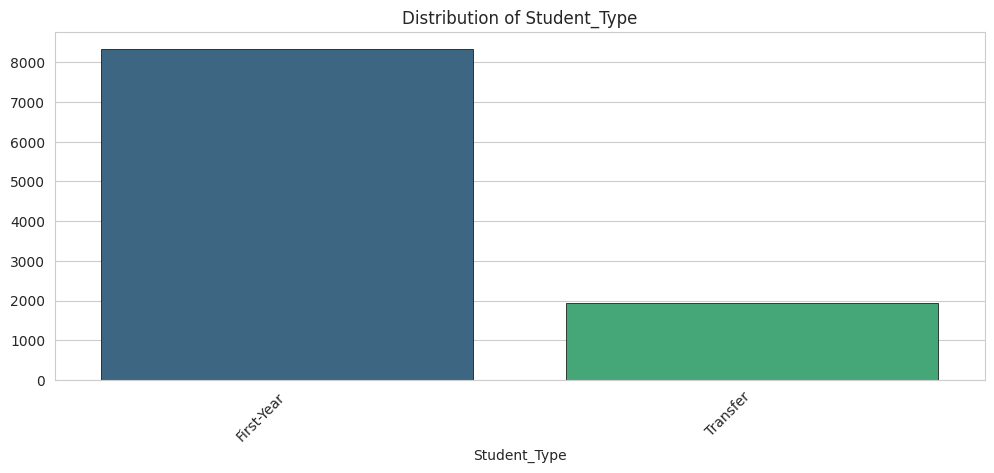

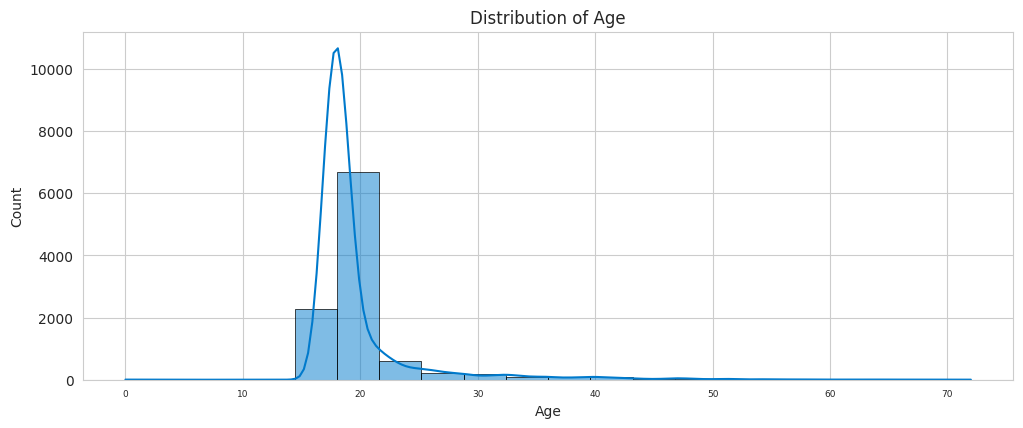

<ipython-input-37-6312fcd03577>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis", edgecolor="black", linewidth=0.5)
<ipython-input-37-6312fcd03577>:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(truncated_wrapped_labels, fontsize=font_size, rotation=45, ha="right")


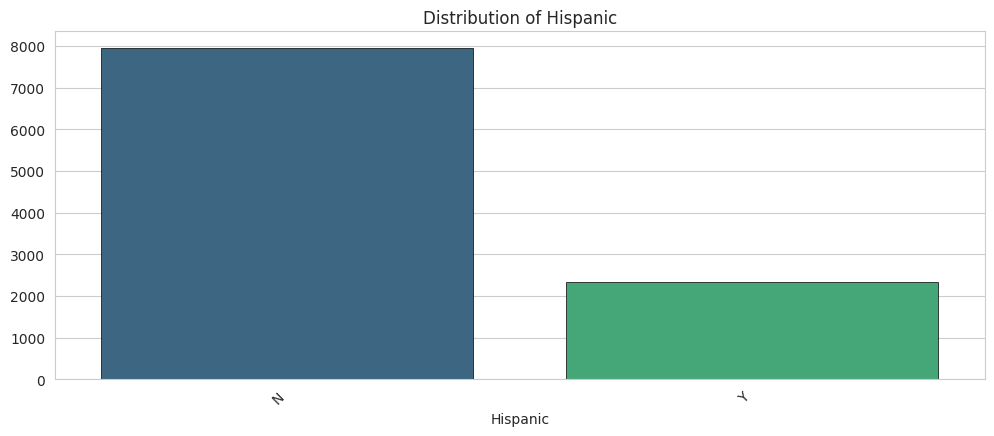

<ipython-input-37-6312fcd03577>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis", edgecolor="black", linewidth=0.5)
<ipython-input-37-6312fcd03577>:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(truncated_wrapped_labels, fontsize=font_size, rotation=45, ha="right")


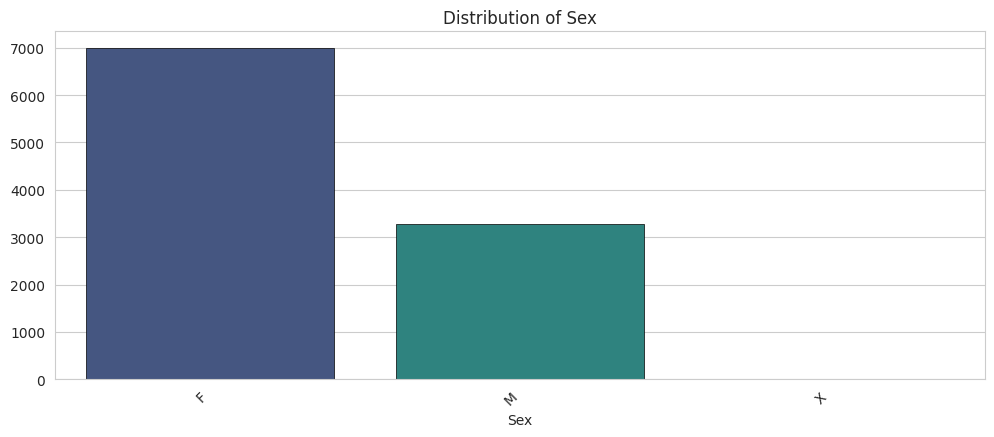

<ipython-input-37-6312fcd03577>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis", edgecolor="black", linewidth=0.5)
<ipython-input-37-6312fcd03577>:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(truncated_wrapped_labels, fontsize=font_size, rotation=45, ha="right")


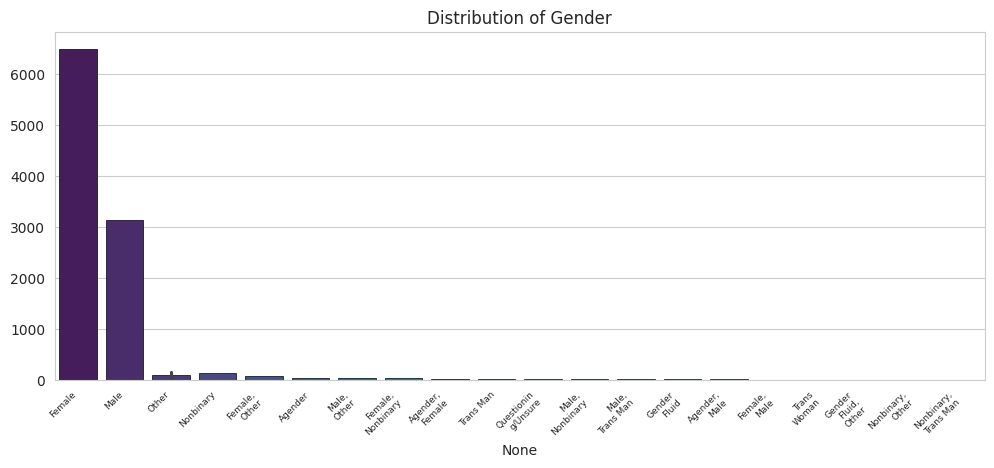

<ipython-input-37-6312fcd03577>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis", edgecolor="black", linewidth=0.5)
<ipython-input-37-6312fcd03577>:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(truncated_wrapped_labels, fontsize=font_size, rotation=45, ha="right")


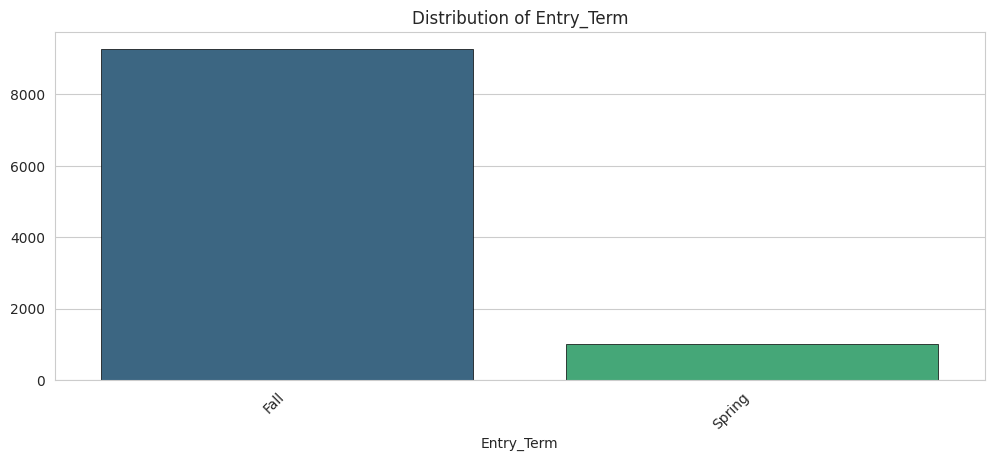

<ipython-input-37-6312fcd03577>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=simplified_citizenship, order=order, palette="viridis", edgecolor="black", linewidth=0.5)


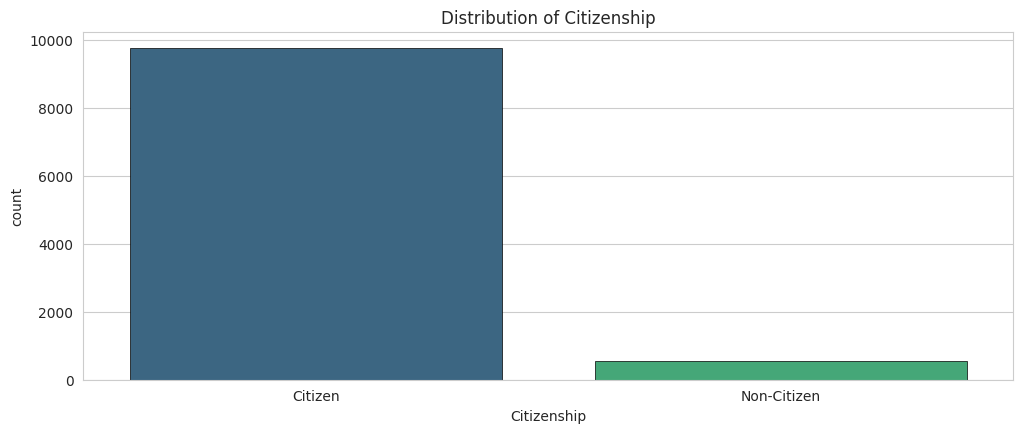

<ipython-input-37-6312fcd03577>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis", edgecolor="black", linewidth=0.5)
<ipython-input-37-6312fcd03577>:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(truncated_wrapped_labels, fontsize=font_size, rotation=45, ha="right")


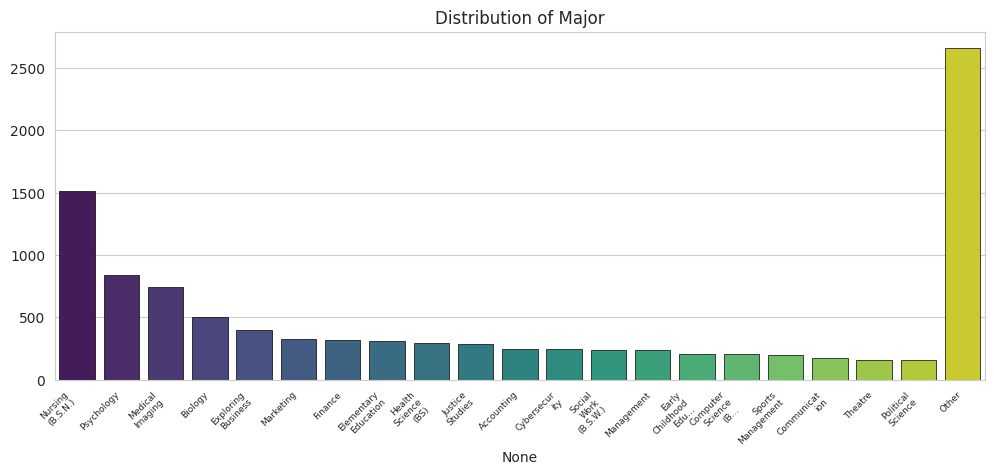

<ipython-input-37-6312fcd03577>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=value_counts.index, x=value_counts.values, palette="viridis", edgecolor="black", linewidth=0.5)
<ipython-input-37-6312fcd03577>:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(truncated_wrapped_labels, fontsize=font_size)


<Figure size 1200x600 with 0 Axes>

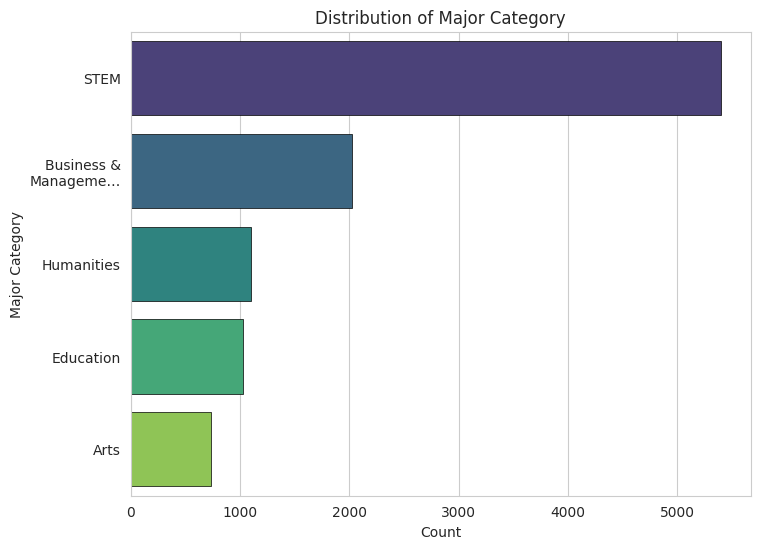

<ipython-input-37-6312fcd03577>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis", edgecolor="black", linewidth=0.5)
<ipython-input-37-6312fcd03577>:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(truncated_wrapped_labels, fontsize=font_size, rotation=45, ha="right")


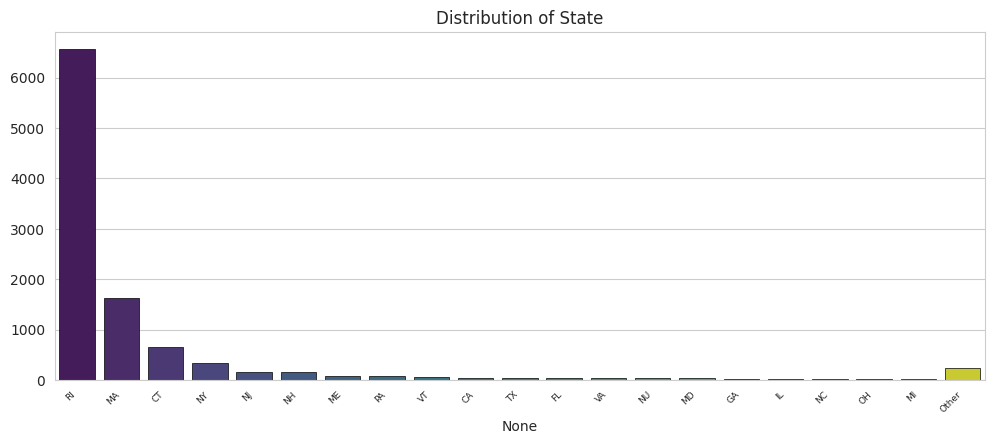

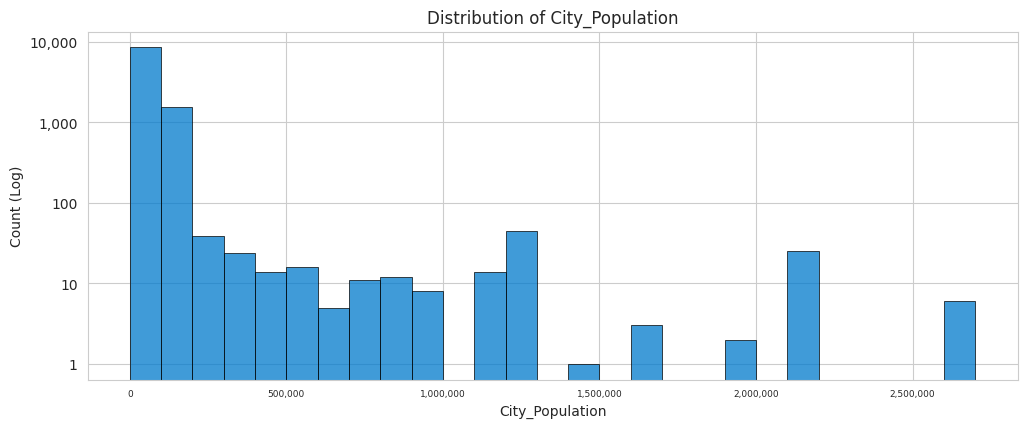

In [ ]:
# Initial Exploratory Analysis (before encoding)

# List of columns to plot
columns_to_plot = ['Student_Type', 'Age', 'Hispanic', 'Sex', 'Gender',
                   'Entry_Term', 'Citizenship', 'Major', 'Major Category', 'State', 'City_Population']

# Maximum number of categories to display in a column chart
MAX_CATEGORIES = 21
MAX_LABEL_LENGTH = 20  # Max length before truncation
CITY_POP_BINS = 100_000  # Bin size for City_Population

# Function to truncate & wrap labels
def truncate_and_wrap_labels(labels, max_length=MAX_LABEL_LENGTH):
    processed_labels = []
    for label in labels:
        if len(label) > max_length:
            label = label[:max_length - 1] + "…"
        processed_labels.append('\n'.join(textwrap.wrap(label, width=max_length // 2)))
    return processed_labels

sns.set_style("whitegrid")

for column in columns_to_plot:
    plt.figure(figsize=(12, 6))

    num_unique_values = Table[column].nunique()
    font_size = 6.5 if num_unique_values > 15 else 10

    # Custom formatting for Citizenship - groups together citizen and non-citizen categories
    if column == "Citizenship":
        simplified_citizenship = Table[column].replace(
            {"Born in USA": "Citizen", "Naturalized": "Citizen"}
        ).apply(lambda x: "Non-Citizen" if x != "Citizen" else x)

        order = simplified_citizenship.value_counts().index
        ax = sns.countplot(x=simplified_citizenship, order=order, palette="viridis", edgecolor="black", linewidth=0.5)

    # Categorical column: Applies column limit (MAX_CATEGORIES)
    elif Table[column].dtype == 'object' or len(Table[column].unique()) < 50:
        value_counts = Table[column].value_counts()

        # Groups "Other" category if more than MAX_CATEGORIES
        if len(value_counts) > MAX_CATEGORIES:
            top_categories = value_counts.iloc[:MAX_CATEGORIES - 1]
            other_count = value_counts.iloc[MAX_CATEGORIES - 1:].sum()

            value_counts = pd.concat([top_categories, pd.Series({"Other": other_count})])

        order = value_counts.index
        truncated_wrapped_labels = truncate_and_wrap_labels(order)  # Applies truncation + wrapping

        # Custom formatting for Major Category graph
        if column == "Major Category":
            plt.figure(figsize=(8, 8))
            ax = sns.barplot(y=value_counts.index, x=value_counts.values, palette="viridis", edgecolor="black", linewidth=0.5)
            ax.set_yticklabels(truncated_wrapped_labels, fontsize=font_size)
            plt.xlabel("Count")
            plt.ylabel("Major Category")
        else:
            ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis", edgecolor="black", linewidth=0.5)
            ax.set_xticklabels(truncated_wrapped_labels, fontsize=font_size, rotation=45, ha="right")

    # Custom formatting for City Population graph
    else:
        if column == "City_Population":
            min_pop = Table[column].min()
            max_pop = Table[column].max()
            bins = np.arange(min_pop, max_pop + CITY_POP_BINS, CITY_POP_BINS)

            ax = sns.histplot(Table[column], bins=bins, kde=False, color="#007acc", edgecolor="black", linewidth=0.5)

            ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
            ax.set_yscale('log')
            ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{int(y):,}"))
            plt.ylabel("Count (Log)")

        else:
            ax = sns.histplot(Table[column], bins=20, kde=True, color="#007acc", edgecolor="black", linewidth=0.5)

    plt.title(f"Distribution of {column}")
    plt.xticks(fontsize=font_size)
    plt.subplots_adjust(bottom=0.3)

    plt.show()



In [ ]:
## One-Hot Encoding with Feature Name Cleaning
def apply_one_hot_encoding(df, exclude_column):
    for column in df.columns:
        if column != exclude_column and df[column].dtype == 'object':
            encoded_column_name = 'ENC-' + column
            encoded_columns_df = pd.get_dummies(df[column], prefix=encoded_column_name, drop_first=True, dtype=int)
            df = pd.concat([df, encoded_columns_df], axis=1)
            df.drop(column, axis=1, inplace=True)

    # Cleans up feature names
    df.columns = (
        df.columns.str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)
                  .str.replace("__+", "_", regex=True)
                  .str.rstrip("_")
    )

    df.columns = df.columns.astype(str)

    return df

# Applies One-Hot Encoding and Feature Cleaning
Table = apply_one_hot_encoding(Table, exclude_column=target)

# Extracts encoded column names for reference
encoded_columns = [col for col in Table.columns if col.startswith('ENC-')]

Table.head(5)


Age Decision    Lat   Long  City_Population  Less_than_high_school  \
0   19    Other  41.94 -71.41          33700.0               0.083892   
1   21    Other  42.08 -71.02          93990.0               0.182259   
2   20    Other  41.94 -71.41          33700.0               0.083892   
3   20    Other  41.37 -71.81          19560.0               0.056559   
4   25    Other  41.87 -71.37          64112.0               0.195299   

   Highschool_or_GED  Some_college_or_associate_s  \
0           0.221278                     0.281614   
1           0.339656                     0.282655   
2           0.221278                     0.281614   
3           0.289586                     0.254700   
4           0.303861                     0.257117   

   Bachelor_s_degree_or_higher  ENC_Student_Type_Transfer  ...  \
0                     0.413217                          1  ...   
1                     0.195430                          1  ...   
2                     0.413217                          1  ...   
3                     0.399154                          1  ...   
4                     0.243723                          1  ...   

   ENC_State_Umujyi_Wa_Kigali  ENC_State_VA  ENC_State_VI  ENC_State_VT  \
0                           0             0             0             0   
1                           0             0             0             0   
2                           0             0             0             0   
3                           0             0             0             0   
4                           0             0             0             0   

   ENC_State_WA  ENC_State_WI  ENC_State_WV  ENC_State_WY  ENC_Country_USA  \
0             0             0             0             0                1   
1             0             0             0             0                1   
2             0             0             0             0                1   
3             0             0             0             0                1   
4             0             0             0             0                1   

   ENC_First_Generation_Y  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  

[5 rows x 1602 columns]

In [ ]:
#Defining variables

predictors = Table.drop(target, axis=1)
target = Table[target]
print("Data Types:")
print(Table.dtypes)

Data Types:
Age                         int64
Decision                   object
Lat                       float64
Long                      float64
City_Population           float64
                           ...   
ENC_State_WI                int64
ENC_State_WV                int64
ENC_State_WY                int64
ENC_Country_USA             int64
ENC_First_Generation_Y      int64
Length: 1602, dtype: object


Shape of DataFrame: (10294, 1602)

Columns in DataFrame (First 10):
Index(['Age', 'Decision', 'Lat', 'Long', 'City_Population',
       'Less_than_high_school', 'Highschool_or_GED',
       'Some_college_or_associate_s', 'Bachelor_s_degree_or_higher',
       'ENC_Student_Type_Transfer'],
      dtype='object')

Data types of columns:
int64      1594
float64       7
object        1
Name: count, dtype: int64

Summary statistics (numerical columns):
                Age           Lat          Long  City_Population  \
count  10294.000000  10294.000000  10294.000000     1.029400e+04   
mean      19.640956     41.339049    -71.740152     7.305481e+04   
std        4.997901      3.508338     11.982087     1.718671e+05   
min        0.000000    -34.300000   -158.100000     0.000000e+00   
25%       18.000000     41.680000    -71.660000     1.483000e+04   
50%       18.000000     41.810000    -71.450000     3.107500e+04   
75%       19.000000     41.900000    -71.370000     7.000400e+04   
max     

<ipython-input-40-c48099ce9c6b>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
<ipython-input-40-c48099ce9c6b>:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


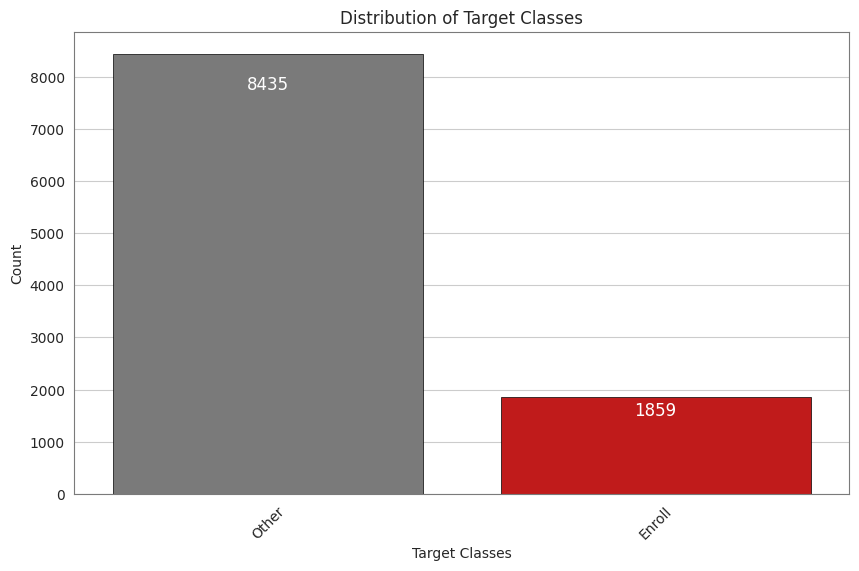


Top Features by Correlation with Target:
Feature: ENC_Major_Psychology, Correlation: -0.0356
Feature: Age, Correlation: -0.0338
Feature: ENC_Race_Asian_White, Correlation: -0.0267
Feature: ENC_First_Generation_Y, Correlation: 0.0266
Feature: ENC_Major_Management, Correlation: 0.0257
Feature: ENC_Major_Category_STEM, Correlation: -0.0255
Feature: ENC_State_NH, Correlation: 0.0240
Feature: ENC_Gender_Female, Correlation: -0.0238
Feature: ENC_State_RI, Correlation: 0.0237
Feature: ENC_Entry_Term_Spring, Correlation: -0.0232
Feature: ENC_Major_Early_Childhood_Education, Correlation: 0.0216
Feature: ENC_Student_Type_Transfer, Correlation: -0.0212
Feature: ENC_Major_Film_Studies, Correlation: 0.0211
Feature: ENC_State_MA, Correlation: -0.0196
Feature: ENC_Major_Exploring_Business, Correlation: 0.0177
Feature: City_Population, Correlation: 0.0174
Feature: ENC_Major_Political_Science, Correlation: 0.0171
Feature: ENC_City_North_Providence, Correlation: 0.0167
Feature: ENC_State_CT, Correlatio

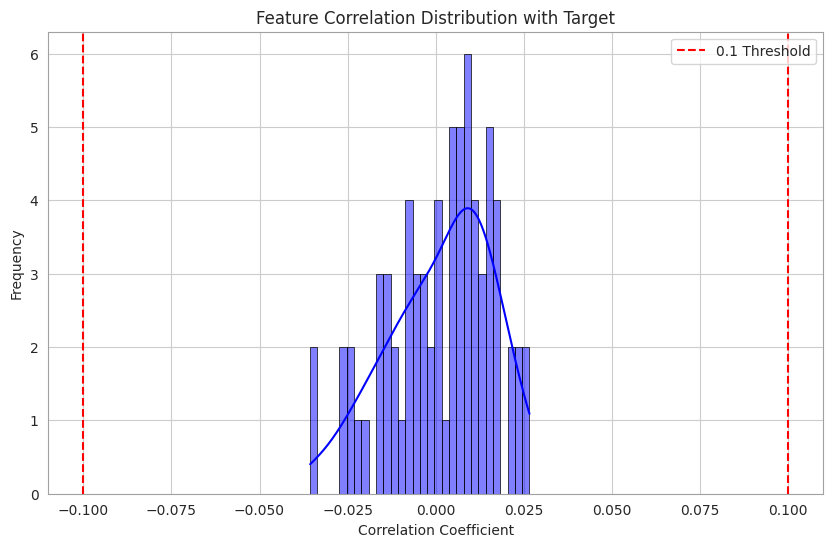

<ipython-input-40-c48099ce9c6b>:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


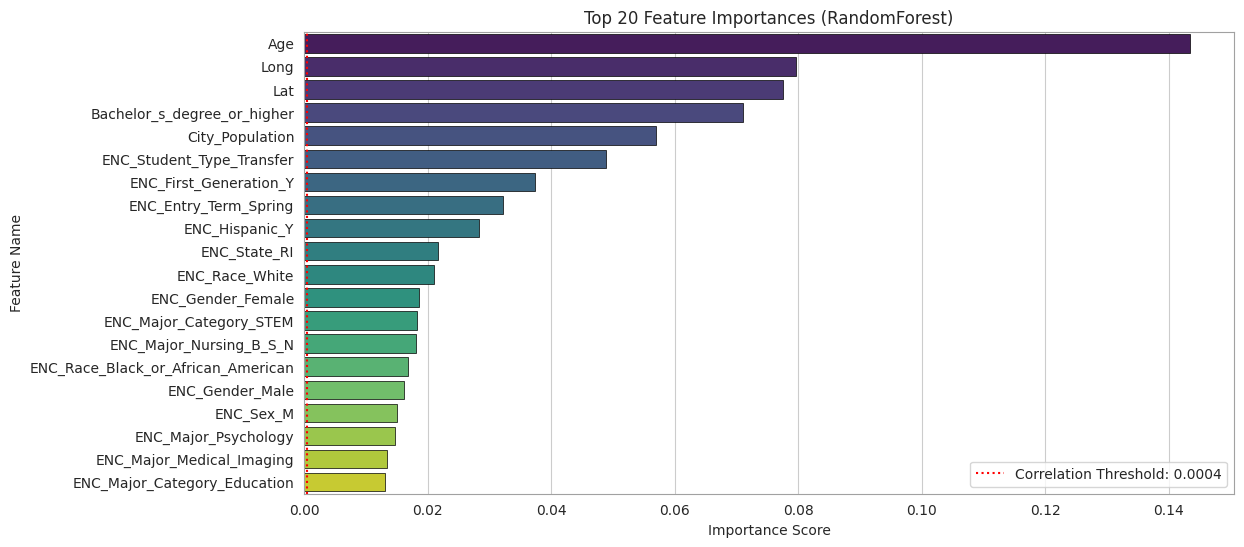

In [ ]:
# Exploratory Analysis

print("Shape of DataFrame:", Table.shape)
print("\nColumns in DataFrame (First 10):")
print(Table.columns[:10])
print("\nData types of columns:")
print(Table.dtypes.value_counts())  # Summary of data types
print("\nSummary statistics (numerical columns):")
print(Table.describe().iloc[:, :10])  # Displays summary for first 10 numerical columns


# Checking for missing values
missing_values = Table.isnull().sum()
missing_summary = missing_values[missing_values > 0]
print("\nMissing Values (Columns with Missing Data):")
print(missing_summary)




# Map
latitude_col = 'Lat'
longitude_col = 'Long'

# Drops rows with missing or invalid values in Lat/Long
Table = Table.dropna(subset=[latitude_col, longitude_col])

# Converts to numeric (in case values are stored as strings)
Table[latitude_col] = pd.to_numeric(Table[latitude_col], errors='coerce')
Table[longitude_col] = pd.to_numeric(Table[longitude_col], errors='coerce')

# Checks if Table has valid coordinates after conversion
if Table[latitude_col].isnull().all() or Table[longitude_col].isnull().all():
    print("No valid latitude and longitude values found.")
else:
    # Centers the map around the mean latitude and longitude
    map_center = [Table[latitude_col].mean(), Table[longitude_col].mean()]

    # Creates a grayscale map using CartoDB Positron or Stamen Toner Lite
    m = folium.Map(location=map_center, zoom_start=6, tiles="CartoDB Positron")

    # Adds points to the map
    for _, row in Table.iterrows():
        if not pd.isnull(row[latitude_col]) and not pd.isnull(row[longitude_col]):
            folium.CircleMarker(
                location=[row[latitude_col], row[longitude_col]],
                radius=3,
                color="blue",
                fill=True,
                fill_color="blue",
                fill_opacity=0.6,
            ).add_to(m)

    m.save("map.html")
    display(m)






# Visualizing the target distribution

plt.figure(figsize=(10, 6))

colors = ['#db0000' if cls == 'DP' else '#7a7a7a' for cls in target.unique()]

ax = sns.countplot(
    x=target,
    palette=colors,
    edgecolor='black',
    linewidth=0.5
)

plt.title('Distribution of Target Classes')
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)


new_labels = ['Enroll' if label == 'DP' else label for label in target.unique()]
ax.set_xticklabels(new_labels)


for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2., p.get_height() - (p.get_height() * 0.05)),
        ha='center', va='top',
        fontsize=12, color='white', fontweight='medium'
    )

for spine in ax.spines.values():
    spine.set_edgecolor('#7a7a7a')

plt.show()





# Converting categorical target (Decision) to numeric using label encoding
label_encoder = LabelEncoder()
numeric_target = label_encoder.fit_transform(target)

# Handling Missing Values and Zero Variance Features Before Correlation
Table = Table.dropna(subset=[target.name])  # Drops rows with missing target values
Table.fillna(Table.median(numeric_only=True), inplace=True)  # Fills missing feature values with median

# Removes zero or near-zero variance columns
selector = VarianceThreshold(threshold=0.01)
filtered_columns = selector.fit_transform(Table.select_dtypes(include=['number']))
filtered_feature_names = Table.select_dtypes(include=['number']).columns[selector.get_support()]

# Rebuilds the DataFrame with filtered numerical columns
Table_filtered = Table[filtered_feature_names]

# Computes Correlations
important_corr = []
correlation_values = []  # Store correlation values for histogram

for column in Table_filtered.columns:
    correlation = Table_filtered[column].corr(pd.Series(numeric_target))
    if not np.isnan(correlation):  # Ignores NaN correlations
        important_corr.append((column, correlation))
        correlation_values.append(correlation)

# Sorts features by absolute correlation
important_corr = sorted(important_corr, key=lambda x: abs(x[1]), reverse=True)

# Displays Top Correlated Features
print("\nTop Features by Correlation with Target:")
for feature, corr in important_corr[:20]:  # Top 20 features
    print(f"Feature: {feature}, Correlation: {corr:.4f}")




# Plots Histogram of Correlations

plt.figure(figsize=(10, 6))

ax = sns.histplot(
    correlation_values,
    bins=30,
    kde=True,
    color='blue',
    edgecolor='black',
    linewidth=0.5
)

# threshold lines
plt.axvline(x=0.1, color='r', linestyle='dashed', label="0.1 Threshold")
plt.axvline(x=-0.1, color='r', linestyle='dashed')

# Titles and labels
plt.title("Feature Correlation Distribution with Target")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Frequency")
plt.legend()

# border
for spine in ax.spines.values():
    spine.set_edgecolor('#a1a1a1')

plt.show()





# Converts categorical target to numeric
label_encoder = LabelEncoder()
numeric_target = label_encoder.fit_transform(target)

# Splits into training and test sets
X_train, X_test, y_train, y_test = train_test_split(Table_filtered, numeric_target, test_size=0.2, random_state=42)

# Trains a RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Gets feature importances
feature_importances = rf_model.feature_importances_

# Creates a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': Table_filtered.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Sets correlation threshold dynamically based on the minimum Random Forest feature importance
correlation_threshold = importance_df['Importance'].min()



# Plots the top 20 features by importance
plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df[:20],
    palette="viridis",
    edgecolor='black',
    linewidth=0.5
)

# Titles and labels
plt.title('Top 20 Feature Importances (RandomForest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')

# Adds correlation threshold as a vertical red dashed line
plt.axvline(
    x=correlation_threshold,
    color='red',
    linestyle='dotted',
    linewidth=1.5,
    label=f'Correlation Threshold: {correlation_threshold:.4f}'
)

# border
for spine in ax.spines.values():
    spine.set_edgecolor('#a1a1a1')

# legend
plt.legend()

plt.show()


In [ ]:
# Prints dynamically determined threshold
print(f"Dynamically Determined Correlation Threshold: {correlation_threshold:.4f}")

# Filters features based on both Pearson correlation and RandomForest importance
high_correlation_features = [
    feature for feature, corr in important_corr
    if abs(corr) >= correlation_threshold and importance_df.set_index('Feature').loc[feature, 'Importance'] >= correlation_threshold
]

# Displays selected features
print("\nSelected Features with High Correlation & Feature Importance:")
print(high_correlation_features)

# Creates a new DataFrame containing only the selected features
high_corr_df = Table[high_correlation_features].copy()
print(high_corr_df.head())

# Assigns predictors
predictors = high_corr_df

print("\nPredictor Names:")
for predictor in predictors.columns.tolist():
    print(predictor)


Dynamically Determined Correlation Threshold: 0.0004

Selected Features with High Correlation & Feature Importance:
['ENC_Major_Psychology', 'Age', 'ENC_Race_Asian_White', 'ENC_First_Generation_Y', 'ENC_Major_Management', 'ENC_Major_Category_STEM', 'ENC_State_NH', 'ENC_Gender_Female', 'ENC_State_RI', 'ENC_Entry_Term_Spring', 'ENC_Major_Early_Childhood_Education', 'ENC_Student_Type_Transfer', 'ENC_Major_Film_Studies', 'ENC_State_MA', 'ENC_Major_Exploring_Business', 'City_Population', 'ENC_Major_Political_Science', 'ENC_City_North_Providence', 'ENC_State_CT', 'Lat', 'ENC_State_NY', 'ENC_Major_Justice_Studies', 'ENC_Major_Marketing', 'ENC_Major_Health_Science_BS', 'ENC_City_Warwick', 'ENC_Citizenship_Permanent_Resident_Must_have_valid_Permanent_Resident_Card', 'ENC_Major_Category_Business_Management', 'ENC_Major_Nursing_B_S_N', 'ENC_Race_Black_or_African_American', 'ENC_Major_Category_Education', 'ENC_Major_Computer_Science_BS', 'ENC_City_West_Warwick', 'ENC_Hispanic_Y', 'ENC_Gender_Other

In [ ]:
### Regression Data Split
X_train, X_test, y_train, y_test = train_test_split(
    predictors, target, random_state = 0
)

X_Test_Non_Scaled = X_test.copy()


In [ ]:
# Converts categorical target labels to numeric since SMOTE expects numeric
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Prints original class distribution (before SMOTE)
print("Original class distribution:")
print(np.bincount(y_train_encoded))

# Applies SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train_balanced = smote.fit_resample(X_train, y_train_encoded)

# Converts back to original labels
y_train = label_encoder.inverse_transform(y_train_balanced)

# Prints new class distribution (after SMOTE)
print("\nNew class distribution after SMOTE:")
print(pd.Series(y_train).value_counts())

Original class distribution:
[1390 6330]

New class distribution after SMOTE:
Other    6330
DP       6330
Name: count, dtype: int64


In [ ]:
#Fitting Scaler
target_scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
#Replacing columns with scaled values

def normalize_numeric_features(X_train, X_test, encoded_columns):
    numeric_columns = X_train.select_dtypes(include=['float64', 'int64', 'int32']).columns
    # Excludes encoded columns from numeric columns
    numeric_columns = [col for col in numeric_columns if not col.startswith('ENC-')]

    scaler = MinMaxScaler()
    normalized_train_features = scaler.fit_transform(X_train[numeric_columns])
    normalized_test_features = scaler.transform(X_test[numeric_columns])

    # Creates DataFrames with the normalized features
    normalized_train_df = pd.DataFrame(normalized_train_features, columns=numeric_columns, index=X_train.index)
    normalized_test_df = pd.DataFrame(normalized_test_features, columns=numeric_columns, index=X_test.index)

    # Creates new dataframes x_train_scaled and x_test_scaled
    X_train_scaled = pd.concat([X_train.drop(columns=numeric_columns), normalized_train_df], axis=1)
    X_test_scaled = pd.concat([X_test.drop(columns=numeric_columns), normalized_test_df], axis=1)

    return X_train_scaled, X_test_scaled, scaler


X_train_scaled, X_test_scaled, scaler = normalize_numeric_features(X_train, X_test, encoded_columns)

X_train_scaled.head(10)

ENC_Major_Psychology       Age  ENC_Race_Asian_White  \
0                   0.0  0.236111                   0.0   
1                   0.0  0.263889                   0.0   
2                   0.0  0.458333                   0.0   
3                   0.0  0.236111                   0.0   
4                   0.0  0.236111                   0.0   
5                   0.0  0.416667                   0.0   
6                   0.0  0.250000                   0.0   
7                   0.0  0.236111                   0.0   
8                   0.0  0.263889                   0.0   
9                   0.0  0.263889                   0.0   

   ENC_First_Generation_Y  ENC_Major_Management  ENC_Major_Category_STEM  \
0                     1.0                   0.0                      0.0   
1                     0.0                   0.0                      0.0   
2                     1.0                   0.0                      0.0   
3                     0.0                   0.0                      0.0   
4                     0.0                   0.0                      0.0   
5                     1.0                   0.0                      0.0   
6                     0.0                   0.0                      0.0   
7                     0.0                   0.0                      0.0   
8                     1.0                   0.0                      0.0   
9                     1.0                   0.0                      1.0   

   ENC_State_NH  ENC_Gender_Female  ENC_State_RI  ENC_Entry_Term_Spring  ...  \
0           0.0                0.0           0.0                    0.0  ...   
1           0.0                0.0           0.0                    0.0  ...   
2           0.0                1.0           1.0                    0.0  ...   
3           0.0                1.0           1.0                    0.0  ...   
4           0.0                0.0           0.0                    0.0  ...   
5           0.0                1.0           1.0                    0.0  ...   
6           0.0                1.0           0.0                    0.0  ...   
7           0.0                0.0           1.0                    0.0  ...   
8           0.0                1.0           0.0                    0.0  ...   
9           0.0                0.0           1.0                    0.0  ...   

   ENC_Major_Biology  Bachelor_s_degree_or_higher  ENC_City_Cumberland  \
0                0.0                     0.391424                  0.0   
1                0.0                     0.870329                  0.0   
2                0.0                     0.370241                  0.0   
3                0.0                     0.337348                  0.0   
4                0.0                     0.391424                  0.0   
5                0.0                     0.369847                  0.0   
6                0.0                     0.700419                  0.0   
7                0.0                     0.682045                  0.0   
8                0.0                     0.391424                  0.0   
9                0.0                     0.303051                  0.0   

   ENC_State_NJ  ENC_Race_Asian  ENC_Race_Black_or_African_American_White  \
0           0.0             0.0                                       0.0   
1           0.0             0.0                                       0.0   
2           0.0             0.0                                       0.0   
3           0.0             0.0                                       0.0   
4           0.0             0.0                                       0.0   
5           0.0             0.0                                       0.0   
6           0.0             0.0                                       0.0   
7           0.0             0.0                                       0.0   
8           0.0             0.0                                       0.0   
9           0.0             0.0                   

In [ ]:
# list of ML algorithms to test
models = [
    #LogisticRegression(),
    #DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()
    #ExtraTreesClassifier(),
    #HistGradientBoostingClassifier(),
    #SVC(decision_function_shape='ovr'),
    #KNeighborsClassifier()
]


In [ ]:
# Defines parameters for grid search for each model

parameters = [
    #RandomForestClassifier
     {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    },

    #GradientBoostingClassifier
     {
        'n_estimators': [100, 200, 300, 400],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
]


'''
parameters = [
    # LogisticRegression
    {'C': [0.01, 0.1, 1, 10, 100],
     'penalty': ['l1', 'l2'],
     'solver': ['liblinear']},  # Removed 'lbfgs' to avoid errors

    # DecisionTreeClassifier
    {'max_depth': [None, 10, 20, 30, 50],
     'criterion': ['gini', 'entropy'],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4]},

    # RandomForestClassifier
    {'n_estimators': [50, 100, 200, 500],
     'max_depth': [None, 10, 20, 30, 50],
     'criterion': ['gini', 'entropy'],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4]},

    #GradientBoostingClassifier
    {'n_estimators': [50,100,200],  # Increase trees
    'learning_rate': [0.01, 0.1, 0.2],  # Explore lower learning rates
    'max_depth': [3, 5, 7],  # Allow deeper trees
    'subsample': [0.6, 0.8, 1.0],  # Subsampling ratio for boosting
    'max_features': ['sqrt', 'log2', None]},  # Control feature selection

    # ExtraTreesClassifier
    {'n_estimators': [50, 100, 200, 500],
     'max_depth': [None, 10, 20, 30, 50],
     'criterion': ['gini', 'entropy'],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4]},

    # HistGradientBoostingClassifier
    {'max_iter': [100, 200, 500],
     'learning_rate': [0.01, 0.1, 0.2, 0.5],
     'max_leaf_nodes': [15, 31, 63],
     'min_samples_leaf': [1, 5, 10],
     'l2_regularization': [0.0, 0.1, 0.5]},

    # SVC
    {'C': [0.01, 0.1, 1, 10, 100],
     'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
     'gamma': ['scale', 'auto', 0.01, 0.1, 1],
     'decision_function_shape': ['ovr']},

    # KNeighborsClassifier
    {'n_neighbors': [3, 5, 10, 20],
     'weights': ['uniform', 'distance'],
     'p': [1, 2]},  # p=1 (Manhattan Distance), p=2 (Euclidean)}
]
'''

"\nparameters = [\n    # LogisticRegression\n    {'C': [0.01, 0.1, 1, 10, 100],\n     'penalty': ['l1', 'l2'],\n     'solver': ['liblinear']},  # Removed 'lbfgs' to avoid errors\n\n    # DecisionTreeClassifier\n    {'max_depth': [None, 10, 20, 30, 50],\n     'criterion': ['gini', 'entropy'],\n     'min_samples_split': [2, 5, 10],\n     'min_samples_leaf': [1, 2, 4]},\n\n    # RandomForestClassifier\n    {'n_estimators': [50, 100, 200, 500],\n     'max_depth': [None, 10, 20, 30, 50],\n     'criterion': ['gini', 'entropy'],\n     'min_samples_split': [2, 5, 10],\n     'min_samples_leaf': [1, 2, 4]},\n\n    #GradientBoostingClassifier\n    {'n_estimators': [50,100,200],  # Increase trees\n    'learning_rate': [0.01, 0.1, 0.2],  # Explore lower learning rates\n    'max_depth': [3, 5, 7],  # Allow deeper trees\n    'subsample': [0.6, 0.8, 1.0],  # Subsampling ratio for boosting\n    'max_features': ['sqrt', 'log2', None]},  # Control feature selection\n\n    # ExtraTreesClassifier\n    {'n_

In [ ]:
'''
# This function is used to produce the probability estimates for the ensemble model
def perform_grid_search(model, params):
    grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    return grid_search.best_estimator_

'''
# Defines a function to perform grid search for a given model
def perform_grid_search(model, params):
    grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    return grid_search


In [ ]:
### Iterates through model training/testing to find best model

# Stores results for each model
model_results = []

# Initializing variables to track the best model
best_model = None
best_score = float('-inf')

for model, params in zip(models, parameters):
    print(f"\nTraining {model.__class__.__name__}")

    # Performs grid search
    grid_search = perform_grid_search(model, params)
    best_estimator = grid_search.best_estimator_
    best_train_score = grid_search.best_score_

    # Evaluates model on test data
    test_predictions = best_estimator.predict(X_test_scaled)
    test_score = accuracy_score(y_test, test_predictions)

    # Uses "weighted" averaging for multi-class classification
    precision = precision_score(y_test, test_predictions, average="weighted")
    recall = recall_score(y_test, test_predictions, average="weighted")
    f1 = f1_score(y_test, test_predictions, average="weighted")

    # Stores results
    model_results.append({
        "Model": model.__class__.__name__,
        "Train Accuracy": best_train_score,
        "Test Accuracy": test_score,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

    print(f"Best Cross-Validation Score: {best_train_score:.4f}")
    print(f"Test Accuracy: {test_score:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Updates best model if this one performs better
    if best_train_score > best_score:
        best_score = best_train_score
        best_model = best_estimator

# Converts results to a df
results_df = pd.DataFrame(model_results)
display(results_df)

print("\nBest Performing Model:", best_model.__class__.__name__)
print("Best Cross-Validation Score:", best_score)



Training RandomForestClassifier
Best Cross-Validation Score: 0.8563
Test Accuracy: 0.7720
Precision: 0.7653, Recall: 0.7720, F1 Score: 0.7685

Training GradientBoostingClassifier
Best Cross-Validation Score: 0.8615
Test Accuracy: 0.7754
Precision: 0.7590, Recall: 0.7754, F1 Score: 0.7664


Model  Train Accuracy  Test Accuracy  Precision  \
0      RandomForestClassifier        0.856319       0.771950   0.765279   
1  GradientBoostingClassifier        0.861453       0.775447   0.759050   

     Recall  F1 Score  
0  0.771950  0.768471  
1  0.775447  0.766361


Best Performing Model: GradientBoostingClassifier
Best Cross-Validation Score: 0.8614533965244865


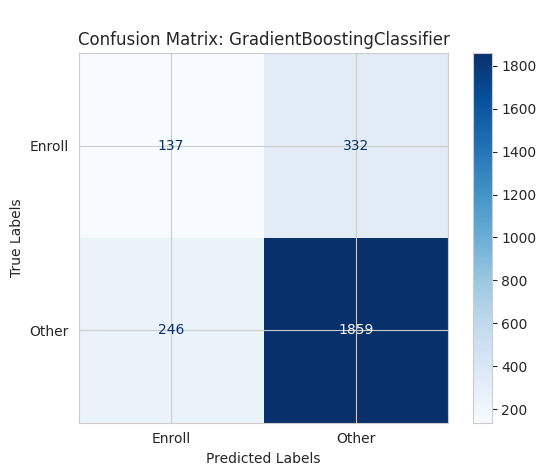

In [ ]:
# confusion matrix of best performing model
cm = confusion_matrix(y_test, test_predictions)

# Modifies class labels
class_labels = [label if label != 'DP' else 'Enroll' for label in best_model.classes_]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d')

plt.title(f"\nConfusion Matrix: {best_model.__class__.__name__}")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



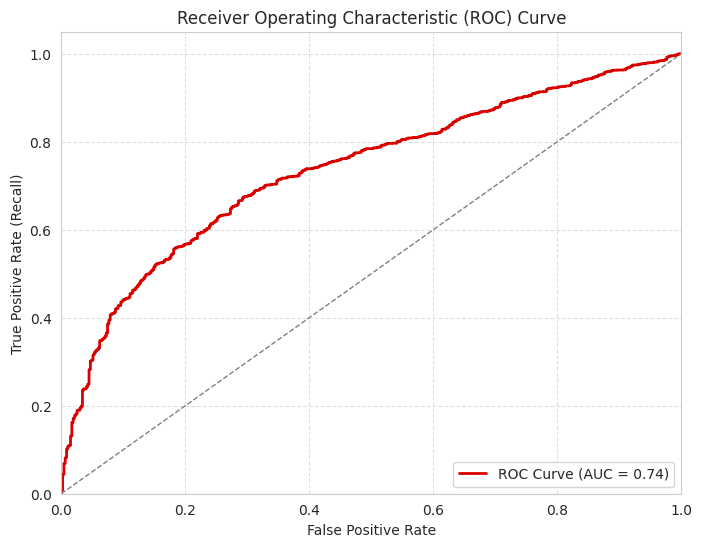

In [ ]:
###Roc Curve

# Converts categorical labels to binary (0,1)
label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)


y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, _ = roc_curve(y_test_binary, y_prob)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="#db0000", lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='dashed', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()



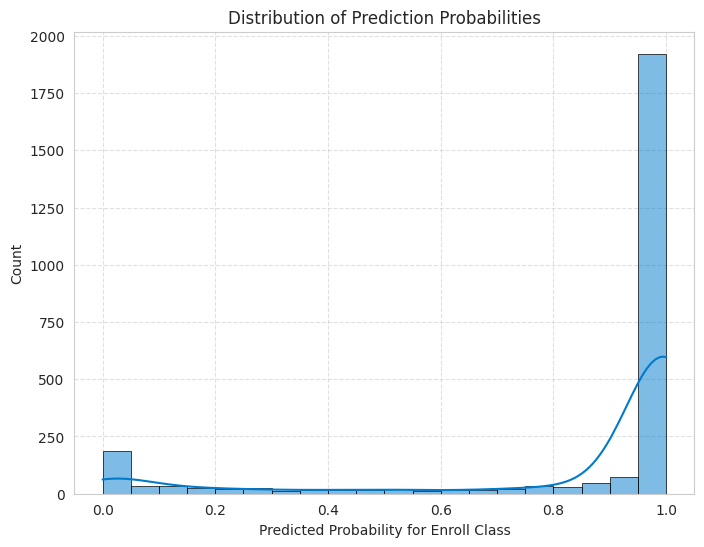

In [ ]:
#Distribution of prediction probabilities

plt.figure(figsize=(8, 6))
sns.histplot(y_prob, bins=20, kde=True, color="#007acc", edgecolor="black", linewidth=0.5)
plt.title("Distribution of Prediction Probabilities")
plt.xlabel("Predicted Probability for Enroll Class")
plt.ylabel("Count")
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


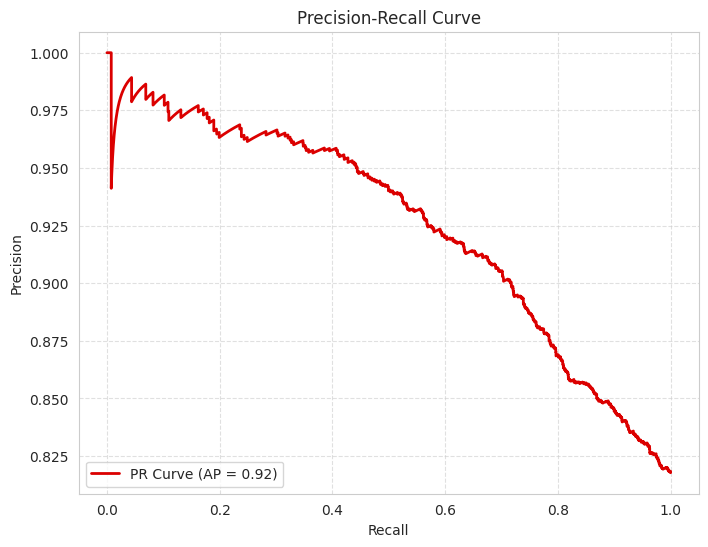

In [ ]:

# precision-recall curve
precision, recall, _ = precision_recall_curve(y_test_binary, y_prob)
avg_precision = average_precision_score(y_test_binary, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="#db0000", lw=2, label=f'PR Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()
